# Molecular Classifier

Source:
+ CLEF 2016,2013 


### 1. Importing Libraries

In [1]:
import os
import sys
module_path = "../src"
#os.environ["WANDB_SILENT"] = "true" # Environment Variable to make wandb silent
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# 1. General Libraries
import pandas as pd
import numpy as np
from pathlib import Path
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
# 2. DataModule & Class Libraries
from utils.label_encoder import label_encoder_target
from utils.calc_stat import calc_dataset_mean_std
from dataset.ImageDataModule import ImageDataModule
from dataset.ImageDataset import ImageDataset
from models.EfficientNetClass import EfficientNetClass
from models.ResNetClass import ResNetClass

# 3. Pytorch & Pytorch Lightning Libraries
from pytorch_lightning import Trainer,seed_everything
from torchvision import transforms
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import torch
# 4. Wandb Tracker Experiements
import wandb

In [3]:
BASE_PATH = Path('/mnt')
print(f"My base path is {BASE_PATH}")
DATA_PATH = '../data/molecular_dataset.csv'
print(f"The given dataset is located here: {DATA_PATH}")
OUTPUT_DIR = Path('/mnt/artifacts/experiments/')
print(f"Let's use this folder: {OUTPUT_DIR} to save our artifacts.")
BASE_IMG_DIR = BASE_PATH /'subfigure-classification'

My base path is /mnt
The given dataset is located here: ../data/molecular_dataset.csv
Let's use this folder: /mnt/artifacts/experiments to save our artifacts.


In [5]:
SEED = 42 
seed_everything(42)
PROJECT = 'Biomedical-Image-Classification-Molecular'
NUM_WORKERS = 72 # workers on the cluster, normally 2 or 4 on a laptop
METRIC_MONITOR = "val_avg_loss"
OUTPUT_PROJECT = OUTPUT_DIR/PROJECT
print(f"Let's use this folder {OUTPUT_PROJECT} to save our sweep iterations")
os.makedirs(OUTPUT_PROJECT, exist_ok=True) # Check if it is false

Let's use this folder /mnt/artifacts/experiments/Biomedical-Image-Classification-Molecular to save our sweep iterations


In [6]:
os.makedirs(OUTPUT_PROJECT, exist_ok=True) # Check if it is false

### 3. Reading the Data & Label Encoding Classes
In this step, we read the csv file and apply a label encoder to the classes in order to run the classifier only with the class "Molecular"

In [7]:
df = pd.read_csv(DATA_PATH, sep='\t')
le_encoder_molecular,dict_label = label_encoder_target(df,target_col='modality')
df.head()

,img,modality,set,source,img_path,higher_modality,caption,split_set
0,1423-0127-16-109-3-1.jpg,D3DR,TRAIN,clef16,2016/train/D3DR/1423-0127-16-109-3-1.jpg,MOLECULAR,A. Three dimensional model of class C protein ...,VAL
1,1423-0127-16-109-3-2.jpg,D3DR,TRAIN,clef16,2016/train/D3DR/1423-0127-16-109-3-2.jpg,MOLECULAR,A. Three dimensional model of class C protein ...,TRAIN
2,1423-0127-17-34-3-1.jpg,D3DR,TRAIN,clef16,2016/train/D3DR/1423-0127-17-34-3-1.jpg,MOLECULAR,Three domains of AAG A (or C)-chain: (a) domai...,TRAIN
3,1423-0127-17-34-3-2.jpg,D3DR,TRAIN,clef16,2016/train/D3DR/1423-0127-17-34-3-2.jpg,MOLECULAR,Three domains of AAG A (or C)-chain: (a) domai...,VAL
4,1423-0127-17-34-3-3.jpg,D3DR,TRAIN,clef16,2016/train/D3DR/1423-0127-17-34-3-3.jpg,MOLECULAR,Three domains of AAG A (or C)-chain: (a) domai...,TRAIN


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


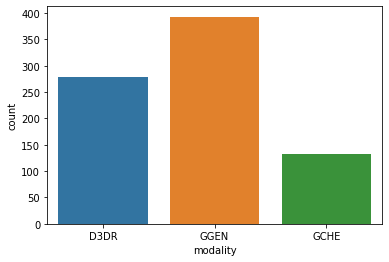

In [8]:
sns.countplot(df['modality'])
plt.show()

In [9]:
transform_list = [
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
]
transform  = transforms.Compose(transform_list)
train_dataset   = ImageDataset   (DATA_PATH,
                                  le_encoder_molecular,
                                  str(BASE_IMG_DIR),
                                  'TRAIN',
                                  image_transform=transform,
                                  label_name='modality',
                                  target_class_col='split_set',
                                  path_col='img_path')

mean, std =calc_dataset_mean_std(train_dataset, batch_size=32, num_workers=72)
print(f"Mean:  {mean}")
print(f"Std :  {std}")


Mean:  tensor([0.8519, 0.8512, 0.8414])
Std :  tensor([0.2773, 0.2772, 0.2900])


### 4. Sweep Running
+ First We will define the image transformations that we are goint to use for the training , evaluation and test

In [10]:
# Image Transformations
# 1.1 Train Transformations
train_transform = [
                    transforms.ToPILImage(),
                    transforms.Resize((256, 256)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomRotation(15),
                    transforms.CenterCrop((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean.numpy(), std.numpy())
                ]
train_transform  = transforms.Compose(train_transform )

# 1.2 Valid Transformations
val_transform = [
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
                ]
val_transform = transforms.Compose(val_transform)

# 1.3 Test Transformations
test_transform = [
                  transforms.ToPILImage(),
                  transforms.Resize((224, 224)),
                  transforms.ToTensor(),
                  transforms.Normalize(mean.numpy(),std.numpy())
                  ]
test_transform = transforms.Compose(test_transform)

In [11]:
print(f"PROJECT NAME: {PROJECT}")
print(f"Metric Monitor: {METRIC_MONITOR}")

PROJECT NAME: Biomedical-Image-Classification-Molecular
Metric Monitor: val_avg_loss


### 4.1 ResnetClassifier

In [12]:
sweep_config = {
  "method": "grid",   # Random search
  "metric": {           # We want to maximize val_acc
      "name": METRIC_MONITOR, # Used accuracy
      "goal": "minimize"
  },
  "parameters": {
        "lr": {
            # log uniform distribution between exp(min) and exp(max)
            "distribution": "categorical",
            "values" : [1e-6,1e-5]
        },
        "fine_tuned_from":{
            "distribution": "categorical",
            "values" : ["whole"]
        },
        "name":{
            "distribution": "categorical",
            "values" : ["resnet18","resnet34","resnet50","resnet101","resnet152"]
        },
        "batch_size":{
            "distribution": "categorical",
            "values" : [16]
            
        }
      
    }
}

In [13]:
sweep_id = wandb.sweep(sweep_config, project=PROJECT)

Create sweep with ID: uktzz2ki
Sweep URL: https://wandb.ai/williamberrios/Biomedical-Image-Classification-Molecular/sweeps/uktzz2ki


In [14]:
OUTPUT_SWEEP = OUTPUT_PROJECT / sweep_id
os.makedirs(OUTPUT_SWEEP, exist_ok=False) # Check if it is false
with open(OUTPUT_SWEEP / 'sweep_config.yml', 'w') as outfile:
    yaml.dump(sweep_config, outfile, default_flow_style=False)

In [15]:
def sweep_iteration():
    # set up W&B logger
    wandb.init()    # required to have access to `wandb.config`
    wandb_logger =  WandbLogger(project=PROJECT, tags=['nb', 'higher-modality'],reinit = True)
    wandb_logger.experiment.save()
    print(f"Name of the Experiment: {wandb_logger.experiment.name}")
    output_run_path = OUTPUT_SWEEP / wandb_logger.experiment.name 
    os.makedirs(output_run_path, exist_ok=False) # Check if it is false

    # setup data
    dm = ImageDataModule( batch_size       = wandb.config.batch_size,
                          label_encoder    = le_encoder_molecular,
                          data_path        = str(DATA_PATH), 
                          base_img_dir     = str(BASE_IMG_DIR),
                          seed             = SEED,   
                          image_transforms = [train_transform,val_transform,test_transform],
                          num_workers      = 72,
                          target_class_col ='split_set',
                          modality_col     ='modality',
                          path_col         ='img_path')
    dm.prepare_data()
    dm.setup()
    dm.set_seed()
    # Callbacks
    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    early_stop_callback = EarlyStopping(
        monitor=METRIC_MONITOR,
        min_delta=0.0,
        patience=5,
        verbose=True,
        mode='min'
    )
    # setup model - note how we refer to sweep parameters with wandb.config
    num_classes = len(df.modality.unique())
    print(f"Num_Classes {num_classes}")
    model = ResNetClass(      name            = wandb.config.name,
                              num_classes     = num_classes,
                              pretrained      = True,
                              fine_tuned_from = wandb.config.fine_tuned_from,
                              lr              = wandb.config.lr,
                              metric_monitor  = METRIC_MONITOR,
                              mode_scheduler  = "min",
                              class_weights   = dm.class_weights,
                              mean_dataset    = mean.numpy(),
                              std_dataset     = std.numpy())
    
    # setup Trainer
    trainer = Trainer(gpus=1,
                  max_epochs=100,                  
                  callbacks=[early_stop_callback,lr_monitor],
                  deterministic= True,
                  logger=wandb_logger,
                  num_sanity_val_steps=0)

    # train
    trainer.fit(model, dm)
    # Save the model
    trainer.save_checkpoint(str(output_run_path / 'final.pt'))
    # Get testS metric
    trainer.test(model, test_dataloaders=dm.val_dataloader())
    del model,trainer,dm
    torch.cuda.empty_cache() 
    wandb.finish()

wandb: Agent Starting Run: okb354eh with config:
wandb: 	batch_size: 16
wandb: 	fine_tuned_from: whole
wandb: 	lr: 1e-06
wandb: 	name: resnet18
wandb: Currently logged in as: williamberrios (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Name of the Experiment: feasible-sweep-1
Num_Classes 3


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 11.2 M
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params


Epoch    49: reducing learning rate of group 0 to 1.0000e-07.


wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).


Accuracy: 94.49540710449219
              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91        36
         1.0       0.93      0.93      0.93        28
         2.0       0.96      1.00      0.98        45

    accuracy                           0.94       109
   macro avg       0.94      0.94      0.94       109
weighted avg       0.94      0.94      0.94       109


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9391534391534391,
 'Macro F1-Score': 0.9403726708074535,
 'test_acc': tensor(94.4954, device='cuda:0'),
 'test_loss': tensor(0.2060, device='cuda:0')}
--------------------------------------------------------------------------------


lr-Adam,0.0
_step,2799
_runtime,643
_timestamp,1613573299
val_acc,94.49541
val_avg_loss,0.206
epoch,49
train_acc,92.66055
train_avg_loss,0.24287
test_acc,94.49541
test_loss,0.206


lr-Adam,███████████████████████████████████████▁
_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄█
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▂▃▃▄▄▅▅▆▆▆▇▇▇▇▇█▇█▇████████████████████
val_avg_loss,█▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train_acc,▁▂▂▃▄▅▅▆▆▇▇▇▇▇▇▇▇▇█▇▇███████████████████
train_avg_loss,█▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁


wandb: Agent Starting Run: i0n8bru0 with config:
wandb: 	batch_size: 16
wandb: 	fine_tuned_from: whole
wandb: 	lr: 1e-06
wandb: 	name: resnet34
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Name of the Experiment: quiet-sweep-2
Num_Classes 3


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 21.3 M
-----------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params


Epoch    40: reducing learning rate of group 0 to 1.0000e-07.


Epoch    48: reducing learning rate of group 0 to 1.0000e-08.


wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).


Accuracy: 95.412841796875
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93        36
         1.0       0.96      0.96      0.96        28
         2.0       0.96      0.98      0.97        45

    accuracy                           0.95       109
   macro avg       0.95      0.95      0.95       109
weighted avg       0.95      0.95      0.95       109


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9529100529100529,
 'Macro F1-Score': 0.9536320487024712,
 'test_acc': tensor(95.4128, device='cuda:0'),
 'test_loss': tensor(0.1520, device='cuda:0')}
--------------------------------------------------------------------------------


lr-Adam,0.0
_step,2743
_runtime,733
_timestamp,1613574035
val_acc,95.41284
val_avg_loss,0.15198
epoch,48
train_acc,94.95412
train_avg_loss,0.17032
test_acc,95.41284
test_loss,0.15198


lr-Adam,█████████████████████████████████▂▂▂▂▂▂▁
_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄█
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_acc,▁▁▂▂▃▄▄▅▅▆▆▆▇▇▇▇▇███████████████████████
val_avg_loss,█▇▇▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train_acc,▁▁▁▂▂▄▄▄▅▆▆▆▆▇▇▇▇▇▇▇████████████████████
train_avg_loss,█▇▇▆▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁


wandb: Agent Starting Run: suj5t01s with config:
wandb: 	batch_size: 16
wandb: 	fine_tuned_from: whole
wandb: 	lr: 1e-06
wandb: 	name: resnet50
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Name of the Experiment: azure-sweep-3
Num_Classes 3


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 23.5 M
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


Epoch    79: reducing learning rate of group 0 to 1.0000e-07.


wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).


Accuracy: 98.16513061523438
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99        36
         1.0       1.00      0.96      0.98        28
         2.0       0.96      1.00      0.98        45

    accuracy                           0.98       109
   macro avg       0.99      0.98      0.98       109
weighted avg       0.98      0.98      0.98       109


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.978835978835979,
 'Macro F1-Score': 0.9819981814470485,
 'test_acc': tensor(98.1651, device='cuda:0'),
 'test_loss': tensor(0.0893, device='cuda:0')}
--------------------------------------------------------------------------------


lr-Adam,0.0
_step,4479
_runtime,1268
_timestamp,1613575307
val_acc,98.16513
val_avg_loss,0.08934
epoch,79
train_acc,98.39449
train_avg_loss,0.08678
test_acc,98.16513
test_loss,0.08934


lr-Adam,███████████████████████████████████████▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_acc,▁▃▅▆▇▇▇▇█▇██████████████████████████████
val_avg_loss,█▇▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▃▅▆▇▇▇▇▇▇▇▇████████████████████████████
train_avg_loss,█▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁


wandb: Agent Starting Run: cu2qg4tb with config:
wandb: 	batch_size: 16
wandb: 	fine_tuned_from: whole
wandb: 	lr: 1e-06
wandb: 	name: resnet101
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Name of the Experiment: feasible-sweep-4
Num_Classes 3


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 42.5 M
-----------------------------------------------
42.5 M    Trainable params
0         Non-trainable params
42.5 M    Total params


Epoch    61: reducing learning rate of group 0 to 1.0000e-07.


Epoch    67: reducing learning rate of group 0 to 1.0000e-08.


wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).


Accuracy: 98.16513061523438
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99        36
         1.0       1.00      0.93      0.96        28
         2.0       0.98      1.00      0.99        45

    accuracy                           0.98       109
   macro avg       0.98      0.98      0.98       109
weighted avg       0.98      0.98      0.98       109


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9761904761904763,
 'Macro F1-Score': 0.9794251072789887,
 'test_acc': tensor(98.1651, device='cuda:0'),
 'test_loss': tensor(0.0901, device='cuda:0')}
--------------------------------------------------------------------------------


lr-Adam,0.0
_step,3807
_runtime,1492
_timestamp,1613576803
val_acc,98.16513
val_avg_loss,0.0901
epoch,67
train_acc,98.16513
train_avg_loss,0.07844
test_acc,98.16513
test_loss,0.0901


lr-Adam,████████████████████████████████████▂▂▂▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▂▃▄▆▆▇▇█▇██████████████████████████████
val_avg_loss,█▇▇▆▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▂▄▆▆▇▇▇▇███████████████████████████████
train_avg_loss,█▇▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁


wandb: Agent Starting Run: iv11s8gl with config:
wandb: 	batch_size: 16
wandb: 	fine_tuned_from: whole
wandb: 	lr: 1e-06
wandb: 	name: resnet152
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Name of the Experiment: cool-sweep-5
Num_Classes 3


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 58.1 M
-----------------------------------------------
58.1 M    Trainable params
0         Non-trainable params
58.1 M    Total params


Epoch    64: reducing learning rate of group 0 to 1.0000e-07.


wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).


Accuracy: 98.16513061523438
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99        36
         1.0       1.00      0.96      0.98        28
         2.0       0.96      1.00      0.98        45

    accuracy                           0.98       109
   macro avg       0.99      0.98      0.98       109
weighted avg       0.98      0.98      0.98       109


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.978835978835979,
 'Macro F1-Score': 0.9819981814470485,
 'test_acc': tensor(98.1651, device='cuda:0'),
 'test_loss': tensor(0.0821, device='cuda:0')}
--------------------------------------------------------------------------------


lr-Adam,0.0
_step,3639
_runtime,1849
_timestamp,1613578656
val_acc,98.16513
val_avg_loss,0.08215
epoch,64
train_acc,99.08257
train_avg_loss,0.06193
test_acc,98.16513
test_loss,0.08215


lr-Adam,███████████████████████████████████████▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_acc,▁▃▆▆▇███████████████████████████████████
val_avg_loss,█▇▆▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_acc,▁▃▅▆▇▇▇▇▇▇▇▇█▇██████████████████████████
train_avg_loss,█▇▇▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▂▁▁▁
test_acc,▁
test_loss,▁


wandb: Agent Starting Run: r3vgwxuy with config:
wandb: 	batch_size: 16
wandb: 	fine_tuned_from: whole
wandb: 	lr: 1e-05
wandb: 	name: resnet18
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Name of the Experiment: revived-sweep-6
Num_Classes 3


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 11.2 M
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params


Epoch    31: reducing learning rate of group 0 to 1.0000e-06.


Epoch    39: reducing learning rate of group 0 to 1.0000e-07.


wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).


Accuracy: 98.16513061523438
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99        36
         1.0       1.00      0.93      0.96        28
         2.0       0.98      1.00      0.99        45

    accuracy                           0.98       109
   macro avg       0.98      0.98      0.98       109
weighted avg       0.98      0.98      0.98       109


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9761904761904763,
 'Macro F1-Score': 0.9794251072789887,
 'test_acc': tensor(98.1651, device='cuda:0'),
 'test_loss': tensor(0.0568, device='cuda:0')}
--------------------------------------------------------------------------------


lr-Adam,0.0
_step,2239
_runtime,661
_timestamp,1613579320
val_acc,98.16513
val_avg_loss,0.05684
epoch,39
train_acc,99.54128
train_avg_loss,0.0272
test_acc,98.16513
test_loss,0.05684


lr-Adam,███████████████████████████████▂▂▂▂▂▂▂▂▁
_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄█
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_acc,▁▅▇▇▇▇███████████▇▇████████▇▇███████████
val_avg_loss,█▅▄▃▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▆▇▇▇▇██████████████████████████████████
train_avg_loss,█▅▃▃▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁


wandb: Agent Starting Run: j470ahey with config:
wandb: 	batch_size: 16
wandb: 	fine_tuned_from: whole
wandb: 	lr: 1e-05
wandb: 	name: resnet34
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Name of the Experiment: wobbly-sweep-7
Num_Classes 3


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 21.3 M
-----------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params


Epoch    18: reducing learning rate of group 0 to 1.0000e-06.


wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).


Accuracy: 96.33026885986328
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96        36
         1.0       1.00      0.93      0.96        28
         2.0       0.96      0.98      0.97        45

    accuracy                           0.96       109
   macro avg       0.97      0.96      0.96       109
weighted avg       0.96      0.96      0.96       109


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9595238095238096,
 'Macro F1-Score': 0.9629666798616571,
 'test_acc': tensor(96.3303, device='cuda:0'),
 'test_loss': tensor(0.0900, device='cuda:0')}
--------------------------------------------------------------------------------


lr-Adam,0.0
_step,1063
_runtime,355
_timestamp,1613579679
val_acc,96.33027
val_avg_loss,0.08999
epoch,18
train_acc,99.99999
train_avg_loss,0.02297
test_acc,96.33027
test_loss,0.08999


lr-Adam,██████████████████▁
_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄█
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▆▇█████▇▇▇████████
val_avg_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇███
train_acc,▁▆▇████████████████
train_avg_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁
test_acc,▁
test_loss,▁


wandb: Agent Starting Run: lvyhixdp with config:
wandb: 	batch_size: 16
wandb: 	fine_tuned_from: whole
wandb: 	lr: 1e-05
wandb: 	name: resnet50
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Name of the Experiment: silver-sweep-8
Num_Classes 3


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 23.5 M
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params


Epoch    16: reducing learning rate of group 0 to 1.0000e-06.


wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).


Accuracy: 97.2477035522461
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        36
         1.0       1.00      0.96      0.98        28
         2.0       0.96      0.98      0.97        45

    accuracy                           0.97       109
   macro avg       0.98      0.97      0.97       109
weighted avg       0.97      0.97      0.97       109


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9714285714285714,
 'Macro F1-Score': 0.9736911236911237,
 'test_acc': tensor(97.2477, device='cuda:0'),
 'test_loss': tensor(0.0670, device='cuda:0')}
--------------------------------------------------------------------------------


lr-Adam,0.0
_step,951
_runtime,332
_timestamp,1613580015
val_acc,97.2477
val_avg_loss,0.06704
epoch,16
train_acc,99.08257
train_avg_loss,0.04611
test_acc,97.2477
test_loss,0.06704


lr-Adam,████████████████▁
_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄█
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
val_acc,▁▅▇▇█████████████
val_avg_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇███
train_acc,▁▆▇▇██▇▇█████████
train_avg_loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁


wandb: Agent Starting Run: l6o6wxxu with config:
wandb: 	batch_size: 16
wandb: 	fine_tuned_from: whole
wandb: 	lr: 1e-05
wandb: 	name: resnet101
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Name of the Experiment: sweet-sweep-9
Num_Classes 3


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 42.5 M
-----------------------------------------------
42.5 M    Trainable params
0         Non-trainable params
42.5 M    Total params


Epoch    22: reducing learning rate of group 0 to 1.0000e-06.


wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).


Accuracy: 99.08256530761719
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        36
         1.0       1.00      0.96      0.98        28
         2.0       0.98      1.00      0.99        45

    accuracy                           0.99       109
   macro avg       0.99      0.99      0.99       109
weighted avg       0.99      0.99      0.99       109


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9880952380952381,
 'Macro F1-Score': 0.9902763902763904,
 'test_acc': tensor(99.0826, device='cuda:0'),
 'test_loss': tensor(0.0386, device='cuda:0')}
--------------------------------------------------------------------------------


lr-Adam,0.0
_step,1287
_runtime,571
_timestamp,1613580590
val_acc,99.08257
val_avg_loss,0.03862
epoch,22
train_acc,99.77064
train_avg_loss,0.02352
test_acc,99.08257
test_loss,0.03862


lr-Adam,██████████████████████▁
_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄█
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_acc,▁▆▇▆▇▇██▇▇▇▇███▇███████
val_avg_loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇███
train_acc,▁▆▇▇▇██████████████████
train_avg_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁


wandb: Agent Starting Run: 0nrsx513 with config:
wandb: 	batch_size: 16
wandb: 	fine_tuned_from: whole
wandb: 	lr: 1e-05
wandb: 	name: resnet152
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Name of the Experiment: dandy-sweep-10
Num_Classes 3


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 58.1 M
-----------------------------------------------
58.1 M    Trainable params
0         Non-trainable params
58.1 M    Total params


Epoch    17: reducing learning rate of group 0 to 1.0000e-06.


wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).


Accuracy: 98.16513061523438
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97        36
         1.0       1.00      1.00      1.00        28
         2.0       0.96      1.00      0.98        45

    accuracy                           0.98       109
   macro avg       0.99      0.98      0.98       109
weighted avg       0.98      0.98      0.98       109


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9814814814814815,
 'Macro F1-Score': 0.9832298136645963,
 'test_acc': tensor(98.1651, device='cuda:0'),
 'test_loss': tensor(0.0549, device='cuda:0')}
--------------------------------------------------------------------------------


lr-Adam,0.0
_step,1007
_runtime,528
_timestamp,1613581122
val_acc,98.16513
val_avg_loss,0.05488
epoch,17
train_acc,99.99999
train_avg_loss,0.01884
test_acc,98.16513
test_loss,0.05488


lr-Adam,█████████████████▁
_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄█
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▃▆▆▃▆▃▆▆▃▃██▃▃▃▃▃
val_avg_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇███
train_acc,▁▆▆▇▇▇▇▇██████████
train_avg_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


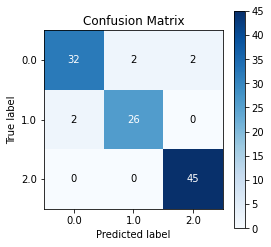

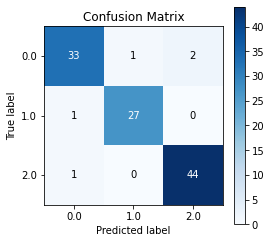

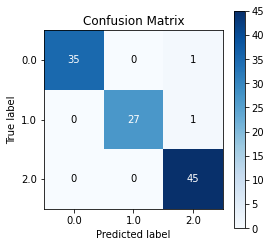

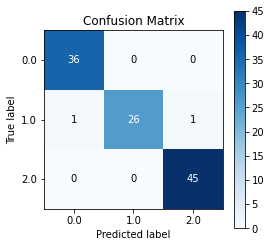

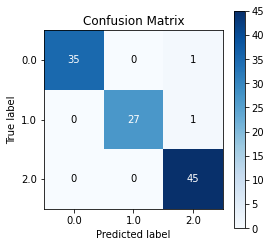

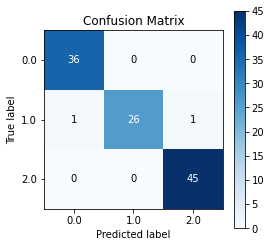

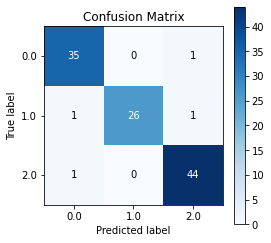

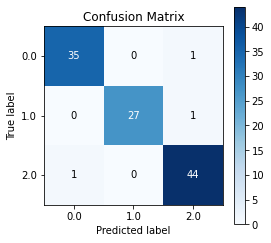

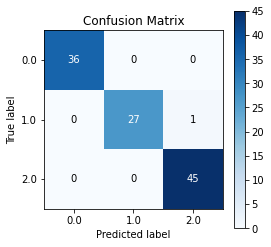

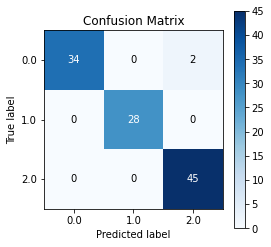

In [16]:
wandb.agent(sweep_id, function=sweep_iteration);